
Notebook 1
==============
Data Visualization

# Importing Packages and Data

In [1]:
import pyfra
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from pylab import *
%matplotlib inline

# Importing Data

In [2]:
french_categories = {'characteristics': 'caracteristiques', 'places':'lieux', 'users':'usagers', 'vehicles':'vehicules'}
data_categories = french_categories.keys()
categories_dict = dict(zip(data_categories, [0,0,0,0]))

In [3]:
def read_csv_of_year(start_year, end_year, separators, name_separator='_'):
    '''Imports the 4 csv files for the given time range and returns them as a dictionary'''
    if len (separators)<4:
        separators = [separators]*4
        
    df_dict = {}
    for year in range(start_year,end_year+1):
        this_year_str = str(year)
        # Data Category
        this_df_dict = {}        
        for this_category, this_sep in zip(data_categories, separators):
            # We need the French name of the category for the filename
            this_french_category = french_categories[this_category]
            this_file_path_and_name = '../data/'+this_year_str+'/' + this_french_category+name_separator+this_year_str+'.csv'
            this_df_dict[this_category] = pd.read_csv(this_file_path_and_name, encoding='latin-1', sep=this_sep, low_memory=False)
        df_dict[year] = this_df_dict
    return df_dict

# Import years
df_dict = {}
df_dict.update(read_csv_of_year(2005, 2008, separators=','))
df_dict.update(read_csv_of_year(2009,2009, separators=['\t', ',', ',', ',']))
df_dict.update(read_csv_of_year(2010, 2016, separators=','))
df_dict.update(read_csv_of_year(2017, 2018, separators=',', name_separator='-'))
df_dict.update(read_csv_of_year(2019, 2021, separators=';', name_separator='-'))


## Merge all the Data in one Data Frame for each Category

In [4]:
dict_of_category_dfs = {}
for this_category in data_categories:
    dict_of_category_dfs[this_category] = pd.concat([df_dict[year][this_category] for year in range(2005,2022)], ignore_index=True)

characteristics = dict_of_category_dfs['characteristics']
places = dict_of_category_dfs['places']
users = dict_of_category_dfs['users']
vehicles = dict_of_category_dfs['vehicles']

# Data Cleaning
We will perform some of the cleaning of the data on the individual datasets. Not all cleaning is possible before merging the datasets, so there will be a second round of cleaning.

### Function for calculating the percentage of missing values for each data frame

In [5]:
def na_percentage(df):
  '''Calculate the percentage of missing values for each column of the given DataFrame'''
  return df.isna().sum() *100 / len(df)

In [6]:
for this_category, df in dict_of_category_dfs.items():
    print(this_category+'\n', na_percentage(df),'\n')

characteristics
 Num_Acc     0.000000
an          0.000000
mois        0.000000
jour        0.000000
hrmn        0.000000
lum         0.000000
agg         0.000000
int         0.000000
atm         0.006509
col         0.001694
com         0.000178
adr        12.774581
gps        57.198251
lat        43.427300
long       43.427656
dep         0.000000
dtype: float64 

places
 Num_Acc     0.000000
catr        0.000089
voie        9.556239
v1         56.690481
v2         95.419907
circ        0.140339
nbv         0.243498
pr         42.394463
pr1        42.556646
vosp        0.246173
prof        0.173774
plan        0.203375
lartpc     19.511203
larrout    10.060977
surf        0.171545
infra       0.482181
situ        0.443128
env1       15.027314
vma        85.457720
dtype: float64 

users
 Num_Acc         0.000000
place           4.906241
catu            0.000000
grav            0.000000
sexe            0.000000
trajet          0.019684
secu           16.893474
locp            2.245798

## Places Dataset

### Dropping unwanted columns , which are v1 , v2, vma, voie, env1

In [7]:
# Droped 'Unnamed: 0','v1','v2','vma', because they contained no information.

places = places.drop(['v1','v2','vma','voie','env1'], axis = 1)

### French to English Variables

In [8]:
# Change french names against english names.

places = places.rename(columns = {'catr' : 'Rd_Cat', 'circ' : 'Traf_Direct' , 'nbv' : 'Lanes' ,
                           'pr' : 'Landmark' , 'pr1' : 'Dist_to_Landmark', 'vosp' : 'Add_Lanes', 'prof' : 'Rd_Prof' ,
                          'plan' : 'Rd_Plan' , 'lartpc' : 'Gre_Verge' , 'larrout' : 'Rd_Width', 'surf' : 'Rd_Cond',
                          'infra' : 'Envinmt' , 'situ' : 'Pos_Acc'})
places.head()

,Num_Acc,Rd_Cat,Traf_Direct,Lanes,Landmark,Dist_to_Landmark,Add_Lanes,Rd_Prof,Rd_Plan,Gre_Verge,Rd_Width,Rd_Cond,Envinmt,Pos_Acc
0,200500000001,3.0,2.0,2.0,1.0,430.0,0.0,1.0,1.0,0,63,1.0,0.0,1.0
1,200500000002,2.0,0.0,2.0,0.0,0.0,1.0,1.0,1.0,0,100,1.0,0.0,5.0
2,200500000003,2.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0,0,2.0,0.0,5.0
3,200500000004,3.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,0,0,1.0,0.0,1.0
4,200500000005,3.0,2.0,2.0,24.0,630.0,0.0,1.0,3.0,0,59,2.0,0.0,3.0


### Changing Nans with Zeros

In [9]:
# There is no value = 0 assigned to information in the places data set. 
# Zeros are used in the cleaned data set as a feature to identify original Nans
# and to keep the data set with as much information as possible.

places = places.fillna({'Rd_Cat':0, 'Traf_Direct': 0, 'Lanes':0, 'Add_Lanes':0, 'Rd_Prof':0,'Rd_Plan':0,
                        'Rd_Cond':0, 'Envinmt':0, 'Pos_Acc':0})

### Changing needed "object" Variables to "int" Variables

In [10]:
# Convert 'object' Variables to 'float' Variables

object_list = ['Landmark', 'Dist_to_Landmark', 'Gre_Verge', 'Rd_Width']

places[object_list] = places[object_list].apply(pd.to_numeric, errors='coerce', axis=1)

# Replace empty cells with 'Nans'

places.replace('', np.nan).copy()

# Fill 'Nans' with 0

places = places.fillna({'Landmark':0, 'Dist_to_Landmark': 0, 'Gre_Verge':0, 'Rd_Width':0})

# Convert 'float' Variables to 'int' Variables

float_list = ['Rd_Cat', 'Traf_Direct', 'Lanes', 'Landmark','Dist_to_Landmark', 'Add_Lanes', 'Rd_Prof', 'Rd_Plan',
              'Gre_Verge', 'Rd_Width', 'Rd_Cond', 'Envinmt','Pos_Acc']

places[float_list] = places[float_list].astype(int, errors = 'raise')

print(places.isna().sum())
print()
print(places.info())
print()
print(places.shape)

Num_Acc             0
Rd_Cat              0
Traf_Direct         0
Lanes               0
Landmark            0
Dist_to_Landmark    0
Add_Lanes           0
Rd_Prof             0
Rd_Plan             0
Gre_Verge           0
Rd_Width            0
Rd_Cond             0
Envinmt             0
Pos_Acc             0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1121571 entries, 0 to 1121570
Data columns (total 14 columns):
 #   Column            Non-Null Count    Dtype
---  ------            --------------    -----
 0   Num_Acc           1121571 non-null  int64
 1   Rd_Cat            1121571 non-null  int32
 2   Traf_Direct       1121571 non-null  int32
 3   Lanes             1121571 non-null  int32
 4   Landmark          1121571 non-null  int32
 5   Dist_to_Landmark  1121571 non-null  int32
 6   Add_Lanes         1121571 non-null  int32
 7   Rd_Prof           1121571 non-null  int32
 8   Rd_Plan           1121571 non-null  int32
 9   Gre_Verge         1121571 non-null  int32
 

## Characteristics Dataset

### Translate variable names from French to English

In [11]:
# Translation of the variable nacmes from French to English, also improving the names so that it becomes clearer, what they are about
characteristics.rename(columns={'an': 'year', 'mois':'month', 'jour': 'day', 'hrmn':'hhmm', 
                                'lum': 'daylight', 'agg': 'built-up_area', 'int':'intersection_category', 'atm': 'atmospheric_conditions',
                                'col': 'collision_category', 'com': 'municipality', 'adr':'adress', 'gps': 'gps_origin', 'lat': 'latitude',
                                'long': 'longitude', 'dep': 'department'}, inplace=True)

# Change the values for 'built-up_area' to make it more understandable, 1 means the accident happened in a built-up area and 0 means happened elsewhere. 
characteristics['built-up_area'].replace({1:0, 2:1}, inplace=True)

### Fixing incoherent format of year variable

In [12]:
characteristics['year'].value_counts()

5       87026
7       83850
6       82993
8       76767
9       74409
10      69379
11      66974
12      62250
17      60701
14      59854
16      59432
2019    58840
15      58654
13      58397
18      57783
2021    56518
2020    47744
Name: year, dtype: int64

The year format is inconsistent. Until 2018, the year was relative to the year 2000, e.g. "5" for 2005. This changed, however, in 2019 which was labeled as 2019.
We will change the year format to YYYY.

In [13]:
characteristics['year'].replace({5:2005, 6:2006, 7:2007, 8:2008, 9:2009, 10:2010, 11:2011,
                                                         12:2012, 13:2013, 14:2014, 15:2015, 16:2016, 17:2017, 18:2018}, inplace=True)

### Check

In [14]:
characteristics['year'].value_counts()

2005    87026
2007    83850
2006    82993
2008    76767
2009    74409
2010    69379
2011    66974
2012    62250
2017    60701
2014    59854
2016    59432
2019    58840
2015    58654
2013    58397
2018    57783
2021    56518
2020    47744
Name: year, dtype: int64

### Fix inconsistent time format

The time format inconsistent, sometimes it is hhmm, and sometimes hh:mm. We will therefore remove any ":" from the column 

In [15]:
#remove ':' from hhmm
characteristics['hhmm'] = characteristics['hhmm'].apply(lambda s: int(str(s).replace(':','')))

### Get weekday and weekend feature

In [16]:
characteristics['date'] = pd.to_datetime({'year':characteristics['year'],
                                                                 'month':dict_of_category_dfs['characteristics']['month'],
                                                                 'day':dict_of_category_dfs['characteristics']['day']})

In [17]:
# New variable: weekday, integer from 0 to 6 representing the weekdays from monday to sunday.
characteristics['day_of_week'] = dict_of_category_dfs['characteristics']['date'].apply(lambda x: x.day_of_week)

# New binary variable: is_weekend, 0 for monday to friday and 1 for saturday and sunday
characteristics['is_weekend'] = (dict_of_category_dfs['characteristics']['day_of_week'] > 4).astype('int')

### Remove trailing zeroes from Department variable
The Department codes are followed by a zero for the years 2005--2018, which has no practical use for us. We will therefore eliminate these trailing zeroes.
Also, since 2019 all the data is saved as strings. We will convert everything to strings, as this is nominal data, we will not make any calculations with it.

In [18]:
dc = 750
str(dc).rstrip('0')
#.lstrip

'75'

In [19]:
def department_converter(dep):
    '''
    Takes in a department code as int and returns a string
    e.g. 750 will be '75' for Paris and 201 will be '2B'
    '''
    if dep == 201:
        return '2A'
    elif dep == 202:
        return '2B'
    elif dep>970:
        return str(dep)
    else:
        return str(dep).rstrip('0')

characteristics.loc[(np.less(characteristics['year'],2019)),'department'] = \
    characteristics[(np.less(characteristics['year'],2019))]['department'].apply(department_converter)

### Remove leading zeros from department code
The dataset from 2021 contains leading zeroes for the department codes 1 to 9. These have to be replaced.

In [20]:
characteristics['department'] = characteristics['department'].apply(lambda code: code.lstrip('0'))

### Fill missing values in atmospheric conditions variable

In [21]:
characteristics['atmospheric_conditions'] = characteristics['atmospheric_conditions'].fillna(
    characteristics['atmospheric_conditions'].mode()[0])
characteristics['atmospheric_conditions'].replace({-1, 0}, inplace=True)
characteristics['atmospheric_conditions'].astype('int')

0          1
1          1
2          2
3          1
4          3
          ..
1121566    5
1121567    2
1121568    2
1121569    1
1121570    3
Name: atmospheric_conditions, Length: 1121571, dtype: int32

### Fill missing values in collision category variable

In [22]:
characteristics['collision_category'] = characteristics['collision_category'].fillna(
    characteristics['collision_category'].mode()[0])

## Vehicles dataset

### Translate variable names from French to English

We will translate the variable names from French to English for better interpretability and name them more clear (using small letters).

In [23]:
vehicles = vehicles.rename(columns = {'id_vehicule' : 'id_veh' , 'num_veh' : 'num_veh' ,
                           'senc' : 'direction' , 'catv' : 'cat_veh', 'obs' : 'obstacle', 'obsm' : 'obstacle_movable' ,
                          'choc' : 'initial_point' , 'manv' : 'principal_maneuver' , 'motor' : 'motor_veh', 'occutc' : 'num_occupants'})
vehicles.columns

Index(['Num_Acc', 'direction', 'cat_veh', 'num_occupants', 'obstacle',
       'obstacle_movable', 'initial_point', 'principal_maneuver', 'num_veh',
       'id_veh', 'motor_veh'],
      dtype='object')

### Check of the variables with the most missing values

Variable num_occupants is representing amount of passangers being victims of an accident when they used public transport system. Missing values are caused by not recording value 0 and keeping the cell empty. For this reason we decided to replace the missing values by 0.

In [24]:
vehicles["num_occupants"] = vehicles["num_occupants"].fillna(0)
vehicles['num_occupants'].isna().sum()
vehicles['num_occupants'].value_counts()

0.0      1901517
1.0         7079
2.0         1033
10.0         654
3.0          544
          ...   
97.0           1
73.0           1
102.0          1
82.0           1
78.0           1
Name: num_occupants, Length: 124, dtype: int64

The variable motor_veh represents the type of the motorisation of the vehicle. There are 85 % missing values in this column. Some of the values of this variable don't specificate an exact type but are tracked as unspecified, unknown, or other. We have decided to drop this variable as it doesn't have any significant influence on the target variable. 

In [25]:
vehicles = vehicles.drop(columns=['motor_veh'])

8 Variables have <= 1% missing information, so for those it should be fine to set the missing information just tu zero.

In [26]:
vehicles[['Num_Acc', 'direction', 'cat_veh', 'obstacle', 'obstacle_movable', 'initial_point', 'principal_maneuver']] = vehicles[['Num_Acc', 'direction', 'cat_veh', 'obstacle', 'obstacle_movable', 'initial_point', 'principal_maneuver']].fillna(0)
vehicles.isna().sum()

Num_Acc                     0
direction                   0
cat_veh                     0
num_occupants               0
obstacle                    0
obstacle_movable            0
initial_point               0
principal_maneuver          0
num_veh                     0
id_veh                1635811
dtype: int64

In [27]:
vehicles['id_veh'].fillna(vehicles['num_veh'], inplace=True)
vehicles.drop(columns=['num_veh'], inplace=True)
vehicles.set_index(['Num_Acc', 'id_veh'], inplace=True)

## Ensure Correct Attribution of Users to Vehicles

In [28]:
users['id_vehicule'].fillna(users['num_veh'], inplace=True)
users.drop(columns=['num_veh'], inplace=True)
users.rename(columns={'id_vehicule': 'id_veh'}, inplace=True)
users.set_index(['Num_Acc', 'id_veh'], inplace=True)

## Compute the percentage of missing data

In [29]:
outer_df = users.merge(vehicles, how='outer', left_index=True, right_on=['Num_Acc', 'id_veh']) \
     .merge(characteristics, how='outer', on='Num_Acc') \
     .merge(places, how='outer', on='Num_Acc')

In [30]:
print(f'number of rows:........{outer_df.shape[0]}')
print(f'number of variables:...{outer_df.shape[1]}')
print(na_percentage(outer_df))
del outer_df

number of rows:........2538644
number of variables:...52
Num_Acc                    0.000000
place                      5.993436
catu                       1.143288
grav                       1.143288
sexe                       1.143288
trajet                     1.162747
secu                      17.843620
locp                       3.363410
actp                       3.367388
etatp                      3.365655
an_nais                    1.359348
secu1                     85.526722
secu2                     85.526722
secu3                     85.526722
direction                  0.000867
cat_veh                    0.000867
num_occupants              0.000867
obstacle                   0.000867
obstacle_movable           0.000867
initial_point              0.000867
principal_maneuver         0.000867
year                       0.000000
month                      0.000000
day                        0.000000
hhmm                       0.000000
daylight                   0.000000
built-u

## Left Join for further investigations
We will continue working with the left join of the data, as the missing lines miss the most important variables anyway.

In [31]:
df = users.merge(vehicles, how='left', left_index=True, right_on=['Num_Acc', 'id_veh']) \
     .merge(characteristics, how='left', on='Num_Acc') \
     .merge(places, how='left', on='Num_Acc')
    
print(df.info())
print(na_percentage(df))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2509620 entries, 0 to 2509619
Data columns (total 52 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   Num_Acc                 int64         
 1   place                   float64       
 2   catu                    int64         
 3   grav                    int64         
 4   sexe                    int64         
 5   trajet                  float64       
 6   secu                    float64       
 7   locp                    float64       
 8   actp                    object        
 9   etatp                   float64       
 10  an_nais                 float64       
 11  secu1                   float64       
 12  secu2                   float64       
 13  secu3                   float64       
 14  direction               float64       
 15  cat_veh                 float64       
 16  num_occupants           float64       
 17  obstacle                float64       
 18  ob

# Visualizations

## Correlation of the feature variables with the target

In [38]:
cm = df.corr(numeric_only=True)
#cm = df.corr()
cm['grav'].sort_values(ascending=False)[1:]

catu                      0.248776
locp                      0.183980
secu                      0.166891
etatp                     0.151094
cat_veh                   0.141492
secu1                     0.113319
obstacle                  0.104892
an_nais                   0.103547
sexe                      0.103092
place                     0.096299
secu2                     0.084306
collision_category        0.064211
Pos_Acc                   0.037811
secu3                     0.032462
daylight                  0.031716
Rd_Plan                   0.026259
Rd_Cond                   0.019033
is_weekend                0.016003
day_of_week               0.011163
Rd_Cat                    0.009627
direction                 0.007223
Landmark                  0.007148
Rd_Prof                   0.005457
Num_Acc                   0.003726
year                      0.003726
Lanes                     0.001758
day                      -0.000542
built-up_area            -0.000748
atmospheric_conditio

The list shows the correlation between each variables and the target variable. Note: The decision whether a variable is important or not has to be based on the absolute value of the correlation.

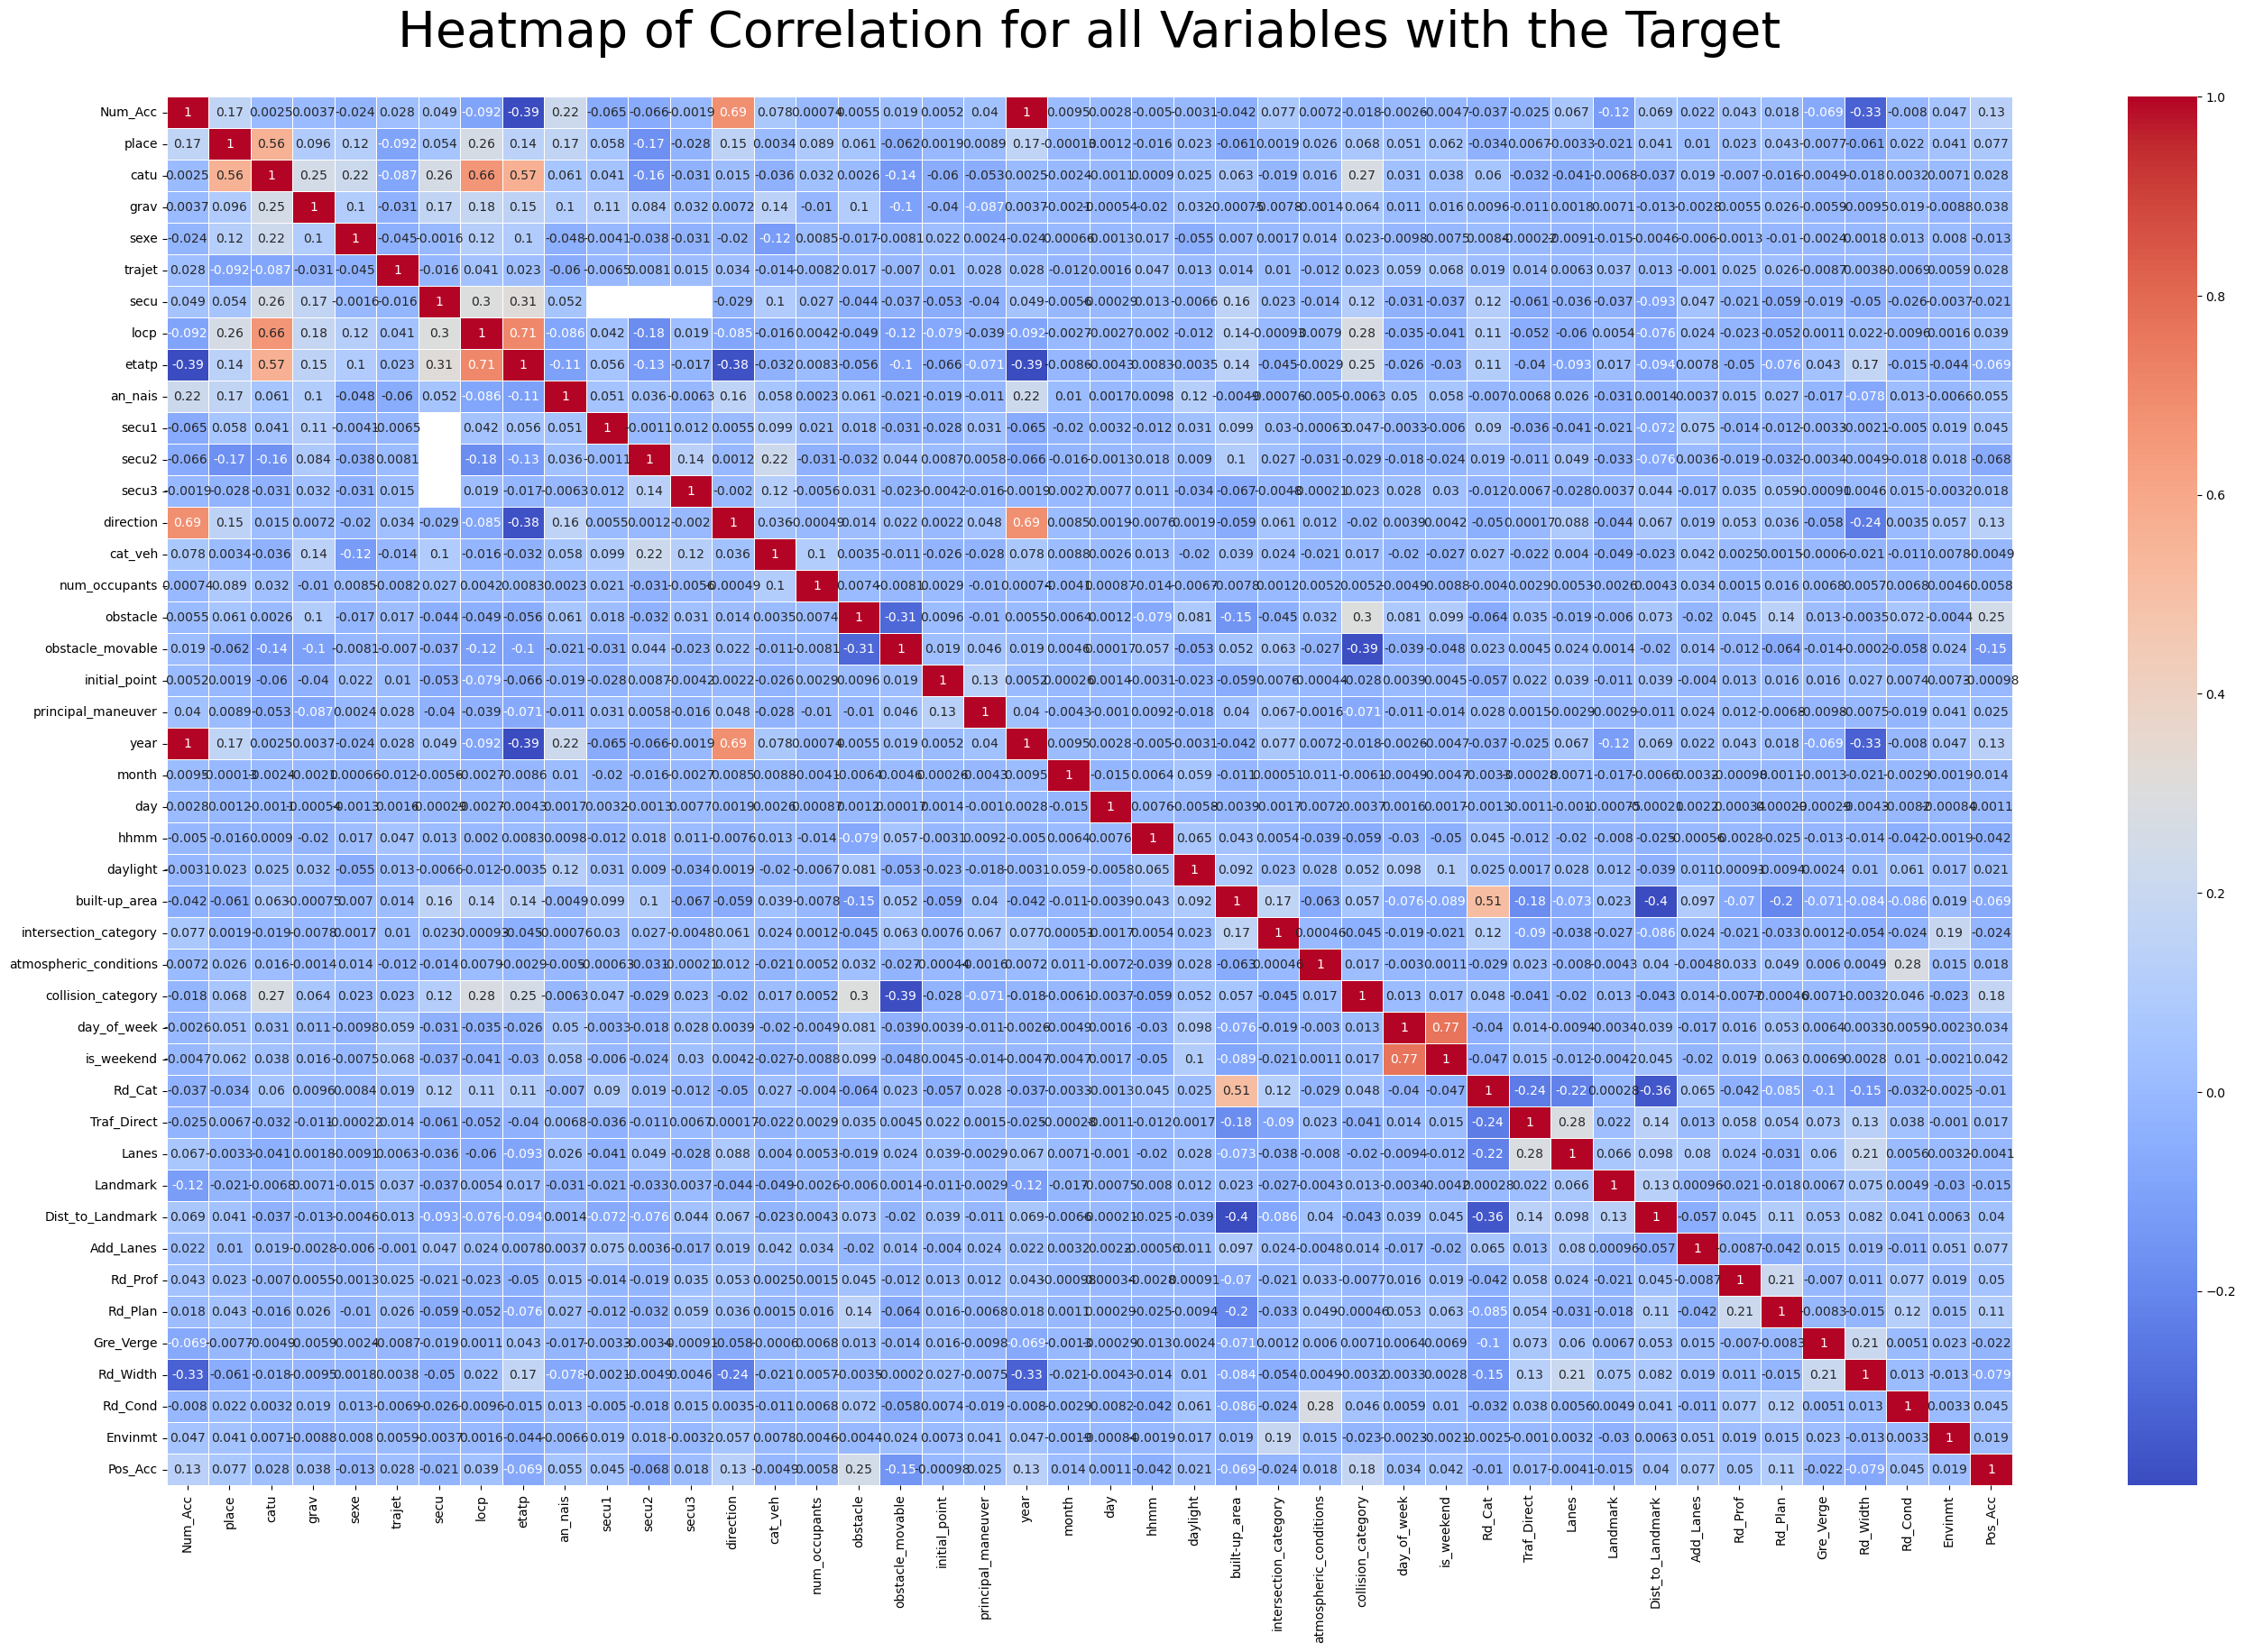

In [39]:
fig, ax = plt.subplots(figsize=(33,20));
sns.heatmap(cm, annot = True, ax = ax, cmap='coolwarm', linewidths = 0.40);
fontsize = 40
plt.title("Heatmap of Correlation for all Variables with the Target", fontdict={'fontsize': fontsize}, pad=40);
plt.savefig('./figures/corr_heatmap.png')

This heat map is intended to provide an overall view of where strong correlations occur .

## Heatmap per Subject Area

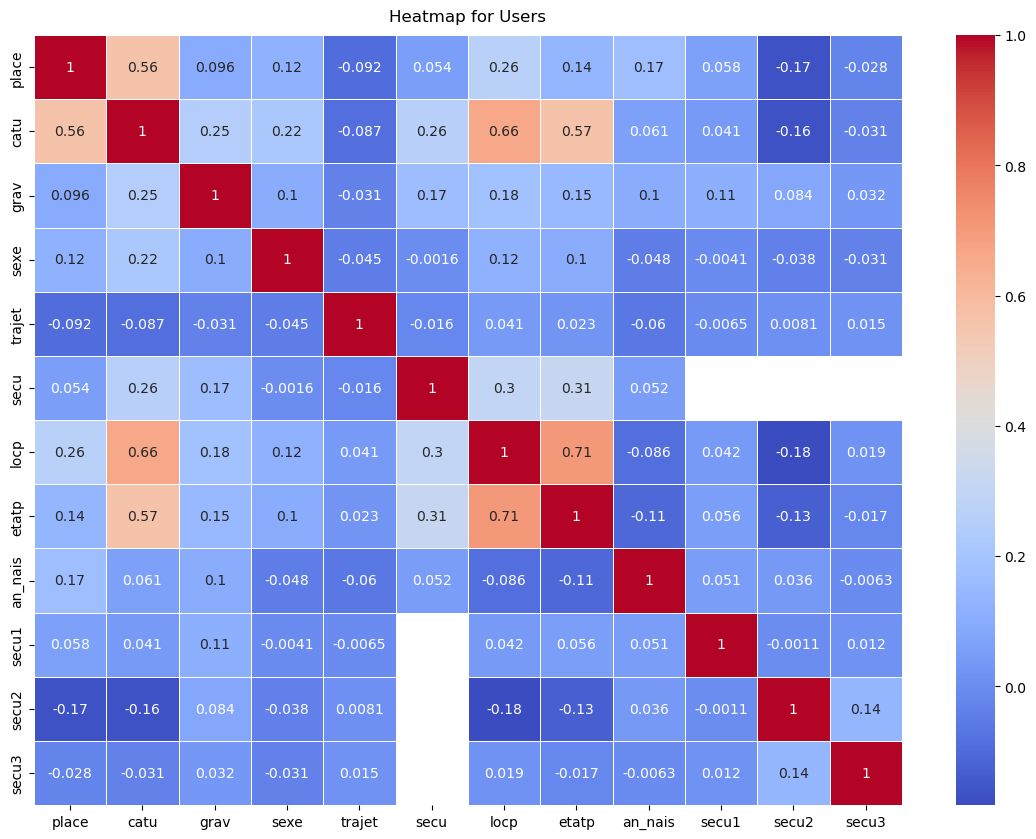

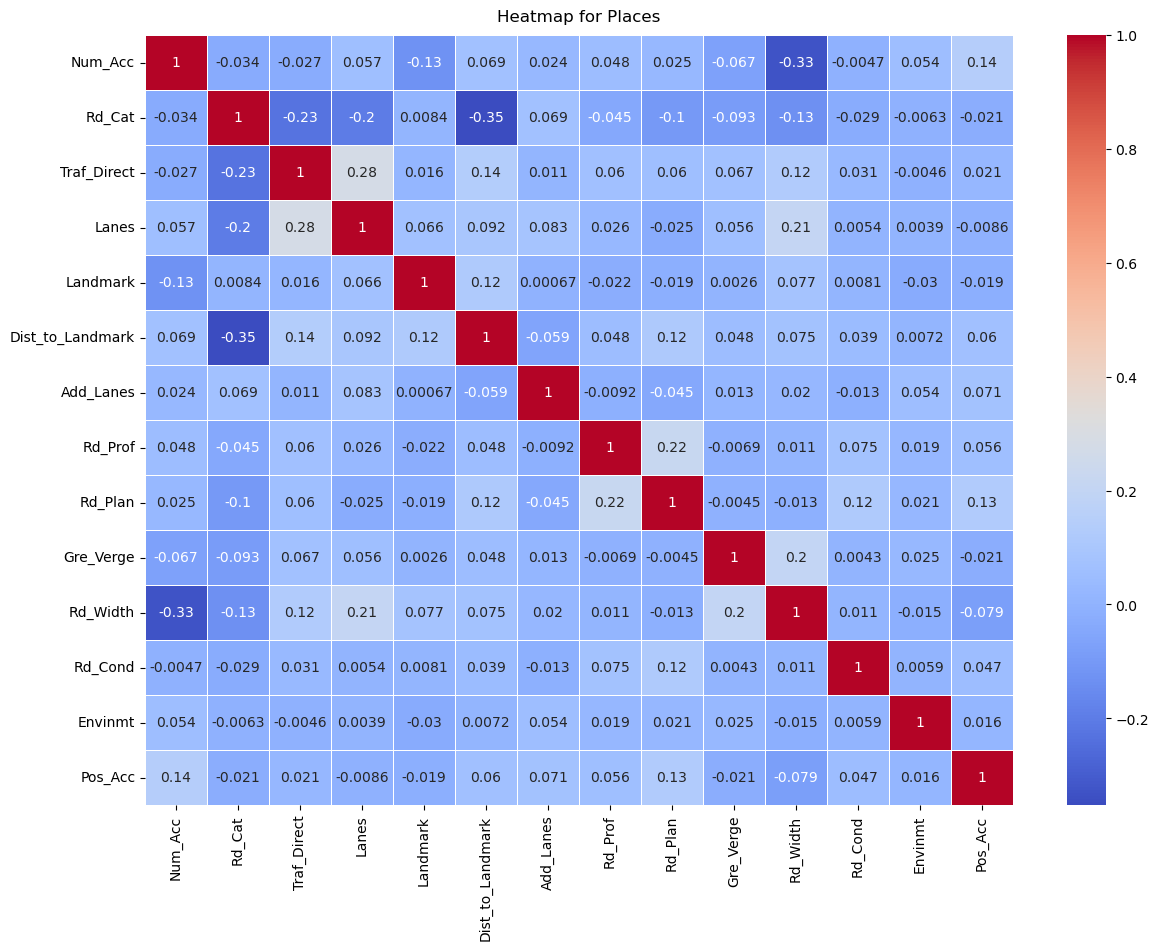

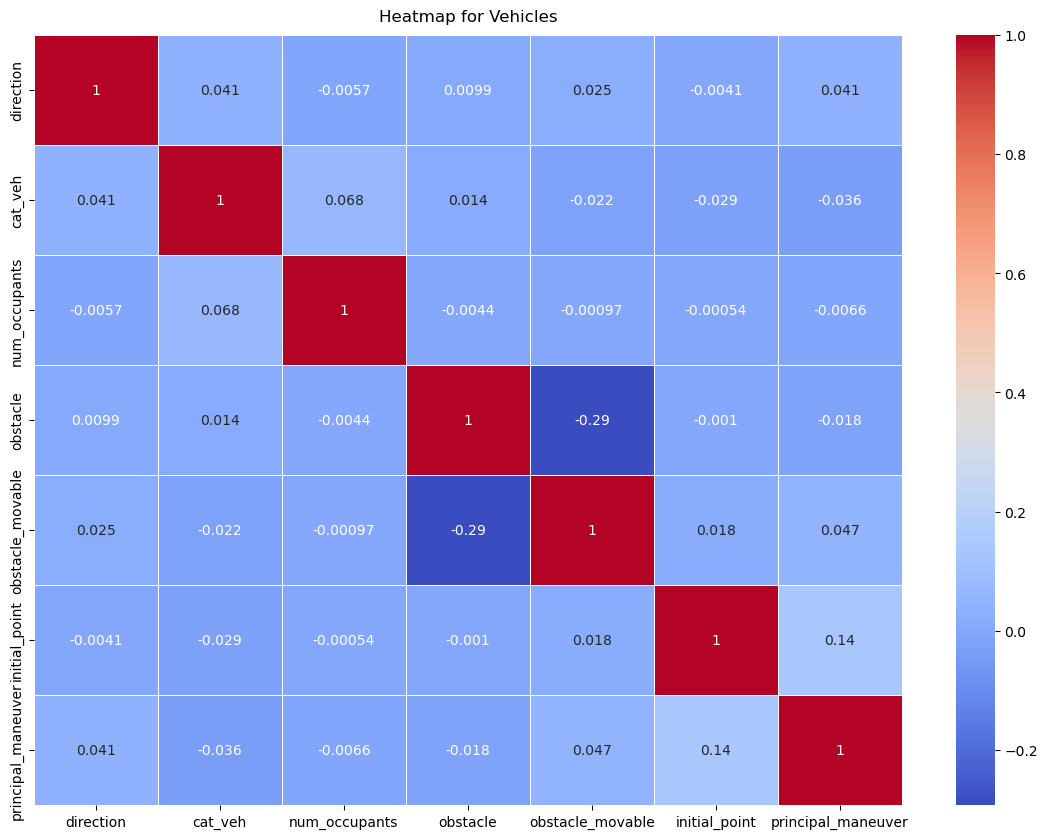

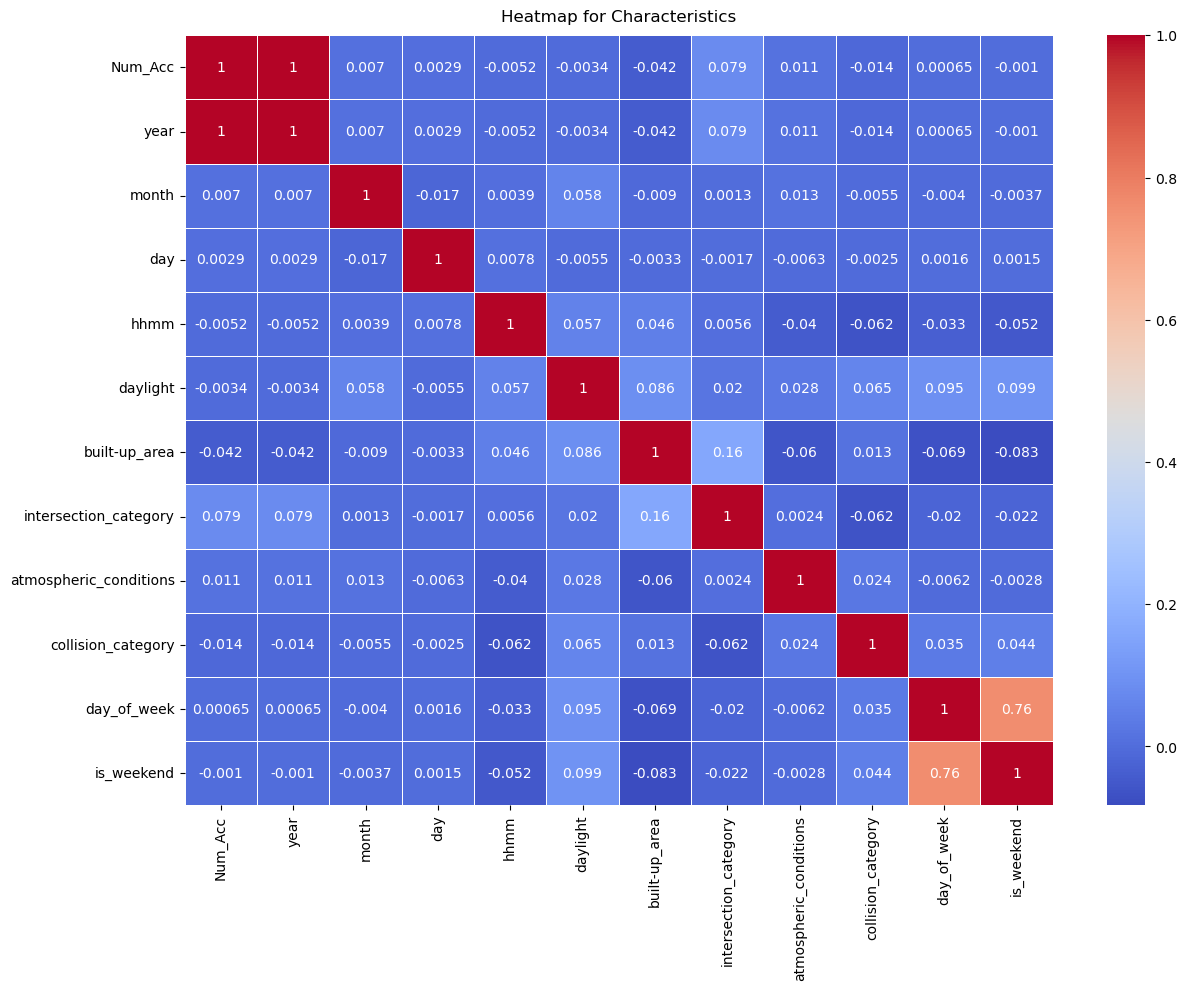

In [40]:
fig, S = plt.subplots(figsize=(14,10));
sns.heatmap(users.corr() , annot = True, cmap='coolwarm',linewidths = 0.40);
plt.title('Heatmap for Users', pad=10)
plt.savefig('./figures/corr_heatmap_USERS.png');

fig, S = plt.subplots(figsize=(14,10));
sns.heatmap(places.corr() , annot = True, cmap='coolwarm',linewidths = 0.40);
plt.title('Heatmap for Places', pad=10)
plt.savefig('./figures/corr_heatmap_PLACES.png');

fig, S = plt.subplots(figsize=(14,10));
sns.heatmap(vehicles.corr() , annot = True, cmap='coolwarm',linewidths = 0.40);
plt.title('Heatmap for Vehicles', pad=10)
plt.savefig('./figures/corr_heatmap_VEHICULES.png');

fig, S = plt.subplots(figsize=(14,10));
sns.heatmap(characteristics.corr() , annot = True, cmap='coolwarm',linewidths = 0.40);
plt.title('Heatmap for Characteristics', pad=10)
plt.savefig('./figures/corr_heatmap_CHARACTERISTICS.png');

## Datetime

We suspect different distributions on weekdays in comparison to weekends. Accidents on weekdays will probably occur mostly when people are commuting to work, i.d. before 09:00 and after 17:00, while on the weekends, people might cause accidents when they return from parties late at night.
We will plot the relative distribution of accidents in two histograms in one figure.
The proportion is relative to the total number of accidents in each category, i.e. 1 different for weekends and weekends.

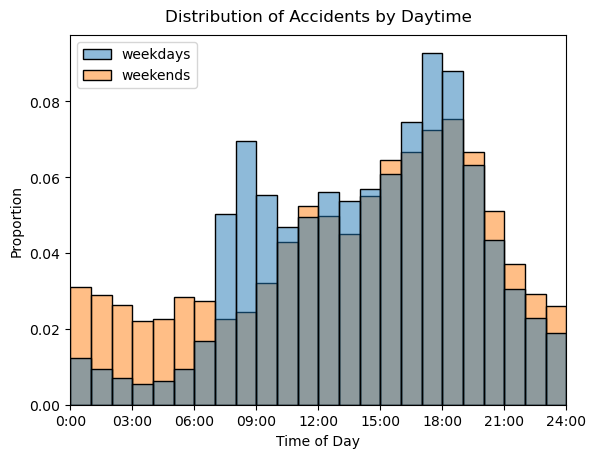

In [41]:
day_time_ticks = (0,300,600,900,1200,1500,1800,2100,2400)
day_time_tick_labels = ('0:00', '03:00','06:00','09:00','12:00','15:00',
                   '18:00','21:00','24:00')
plot_data = pd.DataFrame({'weekdays': (dict_of_category_dfs['characteristics'][dict_of_category_dfs['characteristics']['is_weekend'] != 1 ])['hhmm'],
                 'weekends': (dict_of_category_dfs['characteristics'][dict_of_category_dfs['characteristics']['is_weekend'] == 1 ])['hhmm']})
fig= plt.figure();
sns.histplot(data=plot_data, stat='proportion', bins=24, binrange=(0,2400), common_norm=False);
plt.xticks(ticks=day_time_ticks, 
           labels=day_time_tick_labels);
plt.xlabel('Time of Day')
plt.xlim((0,2400))
plt.title('Distribution of Accidents by Daytime', pad = 10)
plt.savefig('./figures/Accidents by Daytime.png');

The plot shows, that the temporal distribution is different on the weekends: On weekends, there are far more accidents between 19:00 and 07:00, while there are more accidents on weekday around 09:00 and 18:00. These differences align very well with our hypothesis. We did not expect the peak on weekends around 18:00, though. 

Possible policy measures could be more public transport offers during these times and more police inspections on the weekends near party locations.

## Accidents per capita

We will investigate, how the ratio accident / habitant differs between the departments. For this, we will create a new DataFrame of Departments. We will count the accidents per Department and import the population data from INSEE to calculate the ratio. 


We do not expect that this comparison shows stark contrast between the departments. Departments with dense cities will probably have a higher ratio, though. This plot will show us, if there are any outliers.

In [42]:
# Importing data departments from 2019
# source: https://www.insee.fr/fr/statistiques/6011070?sommaire=6011075
departments_2019_df = pd.read_csv('../Data/additional_data/donnees_departements.csv', index_col=2, sep=';')

# Remove leading zeroes from department codes
departments_2019_df.index = departments_2019_df.index.map(lambda idx: idx.lstrip('0'))

# number of accidents by department
n_accidents_by_department = characteristics[characteristics['year']==2019]['department'].value_counts()

# Joining the data
departments_2019_df = departments_2019_df.join(n_accidents_by_department, how='outer') 

# Data is missing for some small departments, we will drop these departments
departments_2019_df.rename(columns={'department':'n_accidents'}, inplace=True)

# Calculate the relative number of accidents per department per 10_000 habitants
departments_2019_df['n_accidents_per_10k'] = departments_2019_df.apply(lambda row: row['n_accidents']*10_000/row['PTOT'] ,axis=1)
departments_2019_df.dropna(axis=0,subset='n_accidents_per_10k', inplace=True)

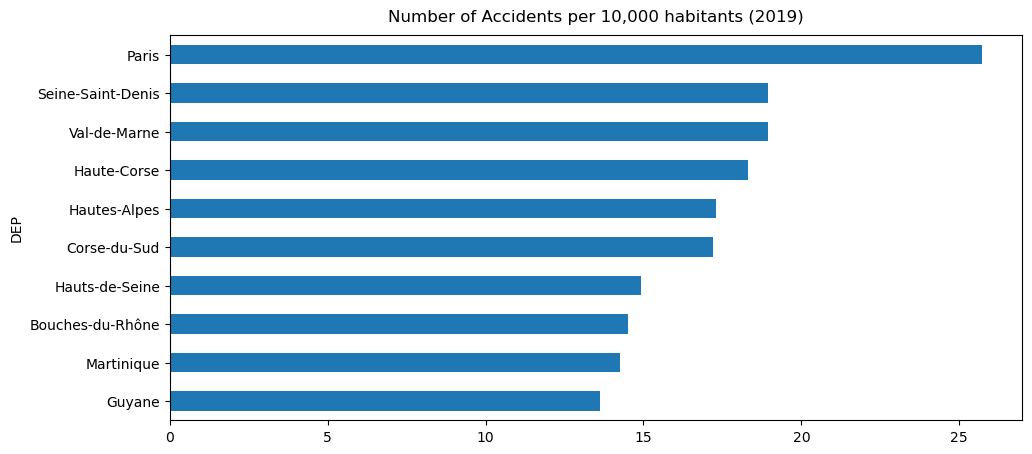

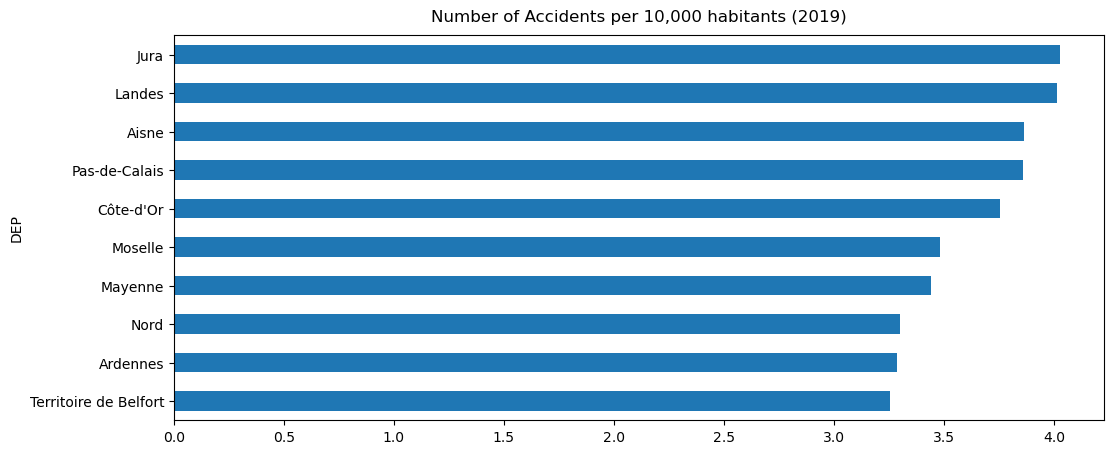

In [43]:
#departments_2019_df['n_accidents_per_10k'].plot(kind='bar')
departments_2019_df.sort_values(by='n_accidents_per_10k').tail(10).plot.barh(x='DEP',y='n_accidents_per_10k',    
    figsize=(11,5), grid=False, title='Number of Accidents per 10,000 habitants (2019)', legend=False);
plt.title('Number of Accidents per 10,000 habitants (2019)',pad = 10)
plt.savefig('./figures/Nb accidents by departement 2019_1.png');

departments_2019_df.sort_values(by='n_accidents_per_10k').head(10).plot.barh(x='DEP',y='n_accidents_per_10k',    
    figsize=(12,5), grid=False, title='Number of Accidents per 10,000 habitants (2019)', legend=False);
plt.title('Number of Accidents per 10,000 habitants (2019)',pad = 10)
plt.savefig('./figures/Nb accidents by departement_2019_2.png');

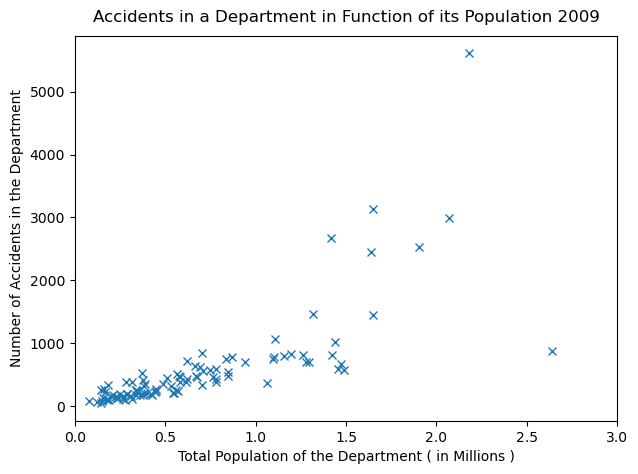

In [44]:
plt.figure(figsize=(7,5));
plt.plot(departments_2019_df['PTOT'], departments_2019_df['n_accidents'], 'x');
plt.title('Accidents in a Department in Function of its Population 2009', pad=10);
plt.xlabel('Total Population of the Department ( in Millions )');
locs,labels = xticks();
xticks(locs, map(lambda x: "%.1f" % x, locs*1e-6));
xlim(left=0);
plt.ylabel('Number of Accidents in the Department')
plt.savefig('./figures/Accidents in terms of population 2009.png');


The differences between the departments are generally higher than expected. Other than the departments without data (which have been dropped before plotting), there are no outliers. The relation between habitants and accidents does not seem to be linear, a quadratic function could be used for fitting here.  

## Checking Accidents per month and per year

In general accidents should be uniform accross all months of the year, and generally accidents should be decreasing across the years especially in covid area since we had a lower volume of car movement across the world

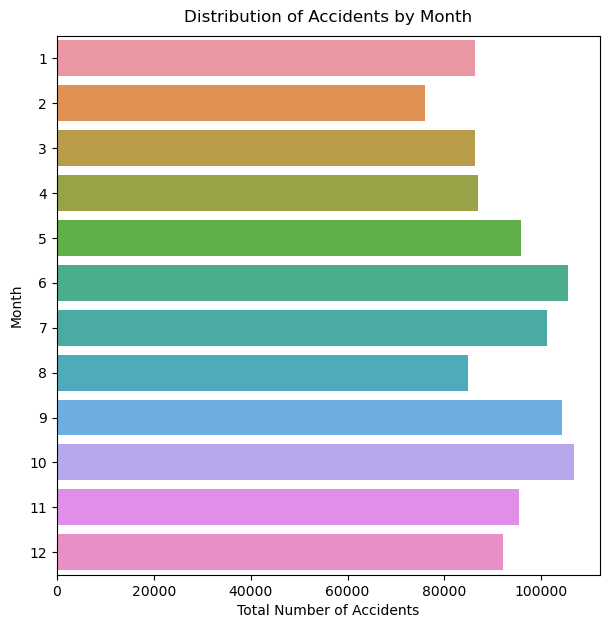

In [45]:
plt.figure(figsize=(7,7));
sns.countplot(y = "month" , data = characteristics)
plt.xlabel('Total Number of Accidents');
plt.ylabel('Month');
plt.title('Distribution of Accidents by Month', pad=10)
plt.savefig('./figures/Accidents per month.png');

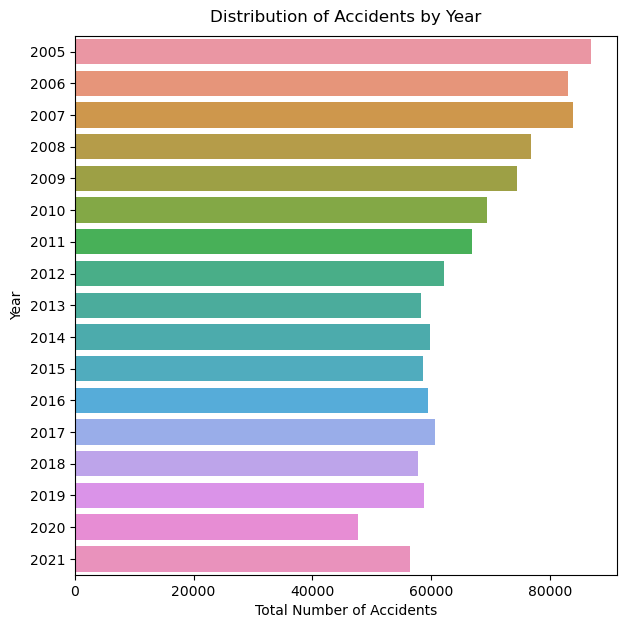

In [46]:
plt.figure(figsize=(7,7));
sns.countplot(y = "year" , data = characteristics)
plt.xlabel('Total Number of Accidents');
plt.ylabel('Year');
plt.title('Distribution of Accidents by Year', pad=10)
plt.savefig('./figures/Accidents per Year.png');

We can see that the number of accidents per month is almost uniform.

For the years we see a decline in the number of accidents per year, maybe for increased security measures or improved laws and roads.
We can also see that there is a sharp decrease in the number in the year 2020 probably due to Covid and lockdown in France, and a relative increase after that in 2021.

## Accidents by Gender

The number of accidents across genders should be equal across males and females.

In [47]:
users.sexe.replace(to_replace=-1,value=1,inplace=True)
users.sexe.value_counts()

1    1691418
2     818202
Name: sexe, dtype: int64

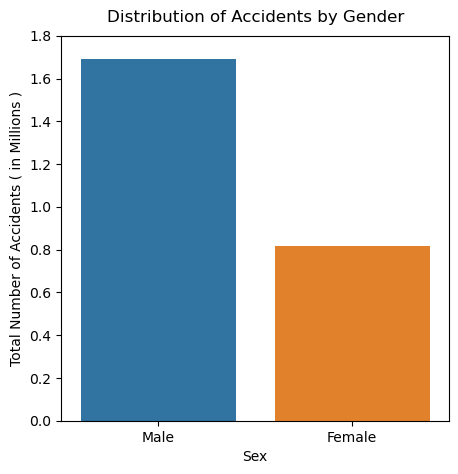

In [48]:
plt.figure(figsize=(5,5));
ax = sns.countplot(data=users, x='sexe');
plt.xticks(ticks=[0,1],labels=['Male', 'Female'])
plt.xlabel('Sex');
plt.ylabel('Total Number of Accidents ( in Millions )');
locs,labels = yticks();
yticks(locs, map(lambda x: "%.1f" % x, locs*1e-6));
ylim(bottom=0);
plt.title('Distribution of Accidents by Gender', pad=10)
plt.savefig('./figures/Accidents by Gender.png');

We see that the amount of Males doing accidents is almost double that of females, probably because the amount of males who generally drive are higher than females, or because males are reckless drivers.

Accidents by Age

In [49]:
df['Age'] = df['year']-df['an_nais']

In [50]:
df.Age.fillna(20,inplace=True) #Mode
df.Age = df.Age.astype(int)

We want to check the amount of accidents by Age and we suspect that the majority is of young age

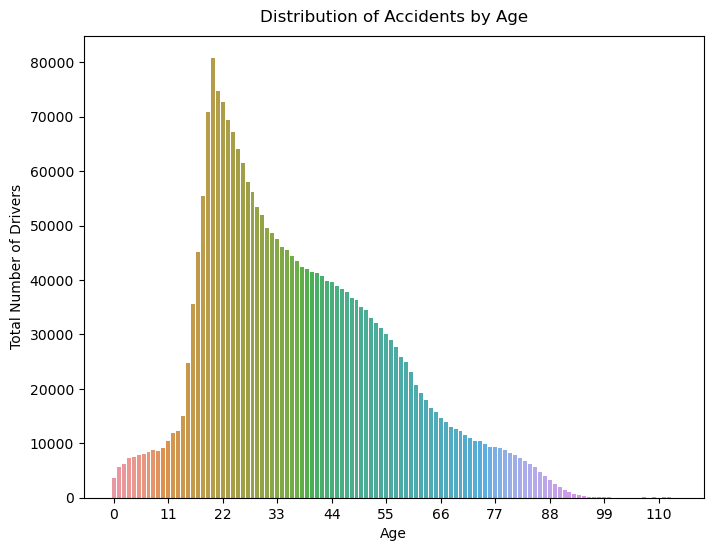

In [51]:
#ENTIRE AGE LIMIT (Include babies in cars)
plt.figure(figsize = (8,6))
ax = sns.countplot(data=df, x='Age');
plt.xlabel('Age');
plt.locator_params(axis='x', nbins=11)
plt.ylabel('Total Number of Drivers');
plt.title('Distribution of Accidents by Age', pad=10);
plt.ticklabel_format(style='plain', axis='y')
plt.savefig('./figures/Accidents per Age.png');

We confirm our theory that the number of accident victims generally decrease with age

## Accidents by Severity

In [52]:
users.grav.replace(to_replace=-1,value=1,inplace=True)
users.grav.value_counts()

1    1029141
4     911852
3     501549
2      67078
Name: grav, dtype: int64

We nee to check the severity (gravity) of accidents and its effects on the dirvers, which is our target variable.
Only a low number of accidents should result in serious injury or death due to the advanced security systems and road designs.

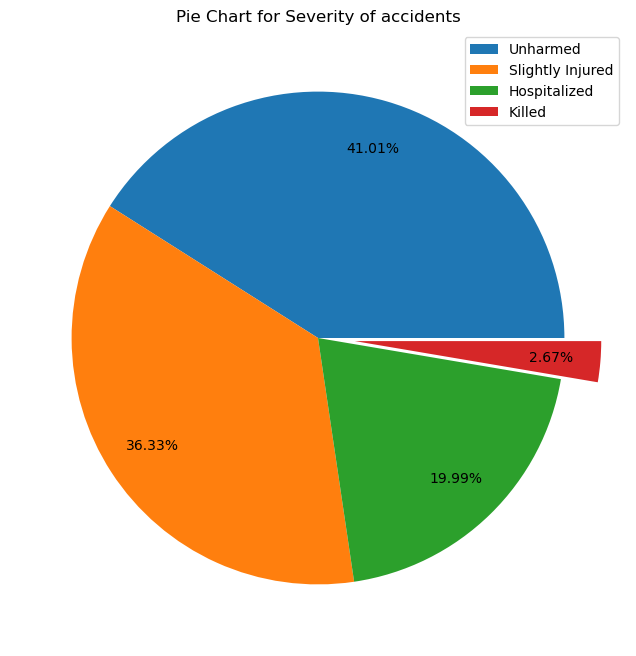

In [53]:
#Pie Chart
plt.figure(figsize = (10,8))
plt.pie(x=users.grav.value_counts(),
        explode = [0,0,0,0.15],
        autopct = lambda x: str(round(x, 2)) + '%',
        labeldistance = 1.1 , pctdistance = 0.8);
plt.title("Pie Chart for Severity of accidents");
plt.legend(['Unharmed', 'Slightly Injured',
        'Hospitalized','Killed']);
plt.savefig('./figures/Nb Accidents by Severity.png');

Conclusion: We can see that almost 20% of people are Hospitalized and only a very small amount is killed,and hence we can deduce that the target variable is unbalanced.

# Violen Plot 

Violen plot to see Grav in terms of Age split by Sex

In [54]:
df.sexe.replace(to_replace=-1,value=1,inplace=True)
df.grav.replace(to_replace=-1,value=1,inplace=True)

<Figure size 1200x1200 with 0 Axes>

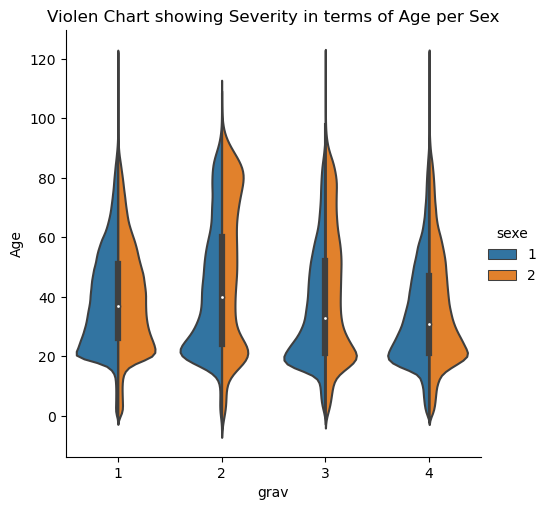

In [55]:
plt.figure(figsize = (12,12))
sns.catplot(x='grav' , y='Age' ,hue = "sexe" , kind = 'violin' , split = True , data = df)
plt.title("Violen Chart showing Severity in terms of Age per Sex")
ax.set(xlabel='Severity')
plt.savefig('./figures/Violen Chart.png');

We can observe that the Age range is quite unifrom across all grav types for both sexes

## Accidents per Road Categories

What types of roads do most accidents happen on? Can roads with high speeds or rather small distances show a clear trend? We would not expect a clear trend.

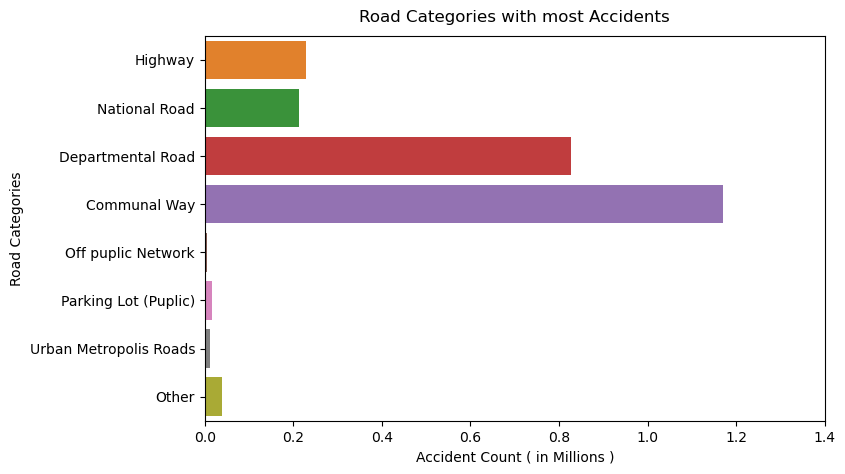

In [56]:
plt.figure(figsize = (8,5));
sns.countplot( y = df.Rd_Cat);
plt.title('Road Categories with most Accidents', pad=10);
plt.yticks(ticks=list(range(0,9)),labels=['Nans','Highway', 'National Road', 'Departmental Road',
                                          'Communal Way' ,'Off puplic Network','Parking Lot (Puplic)' ,
                                          'Urban Metropolis Roads' , 'Other']);
plt.xlabel('Accident Count ( in Millions )');
plt.ylabel('Road Categories');
locs,labels = xticks();
xticks(locs, map(lambda x: "%.1f" % x, locs*1e-6));
ylim(top=0.5);
xlim(left=0)
plt.savefig('./figures/Accidents per Road Category.png');


Most accidents seem to occur in urban areas. Reasons for this can be oncoming traffic, other road users such as cyclists, narrow or dirty lanes.

## Accidents per Road Categories vs. Traffic Direction

In which direction of travel do most accidents occur and does the type of road plays a role here. Can oncoming traffic be a factor?

In [57]:
indexNames = df[ df['Traf_Direct'] < 1 ].index
df.drop(indexNames , inplace=True)

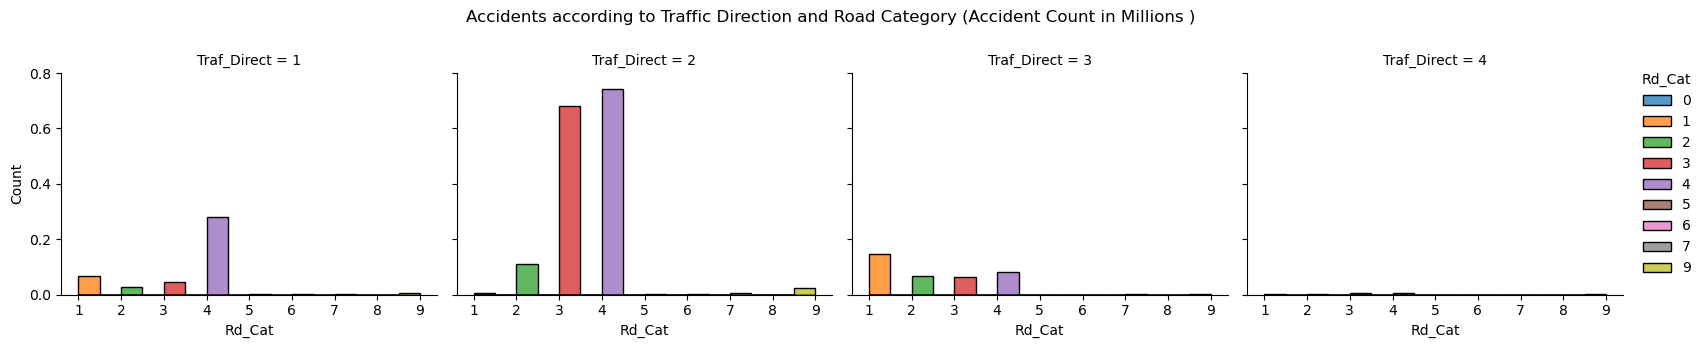

In [58]:
g = sns.FacetGrid(df, col = 'Traf_Direct', col_wrap=4, height=3.5, aspect=1.2,hue='Rd_Cat');
chart = g.map_dataframe(sns.histplot, x='Rd_Cat', binwidth=.5, binrange=(1, 9));
g.add_legend()
g.fig.subplots_adjust(top=0.8);
g.fig.suptitle('Accidents according to Traffic Direction and Road Category (Accident Count in Millions )');
locs,labels = yticks();
yticks(locs, map(lambda x: "%.1f" % x, locs*1e-6));
ylim(bottom=0);
xlim(left=0.6)
plt.savefig('./figures/Accidents by Traffic Direction.png');

Legend:
- Road Categories:---------------------Traffic Directions                   
- 1=Highway--------------------------         - 1=One Way           
- 2=National Road--------------------            - 2=Bidirectional  
- 3=Departmental Road--------------           - 3=Separated Carriageways 
- 4=Communal Way------------------           - 4=With variable assignment Channels    
- 5=Off puplic Network         
- 6=Parking Lot (Puplic)      
- 7=Urban Metropolis Roads
- 9=Other                                            


We can see that with road categories 3 and 4, on which most accidents happen, we have most accidents in places with bidirectional traffic. A suspicion that arose from this, that frontal or side collisions of vehicles on narrow streets with traffic on both sides are the most common, has not been confirmed. In fact, the most common type of collision is the side collision (1.4 million times), but this in turn is distributed fairly evenly across the type of road and traffic direction.

## Road Conditions

In what weather conditions do most accidents happen? We would expect snow, ice, rain, mud as clear evidence.

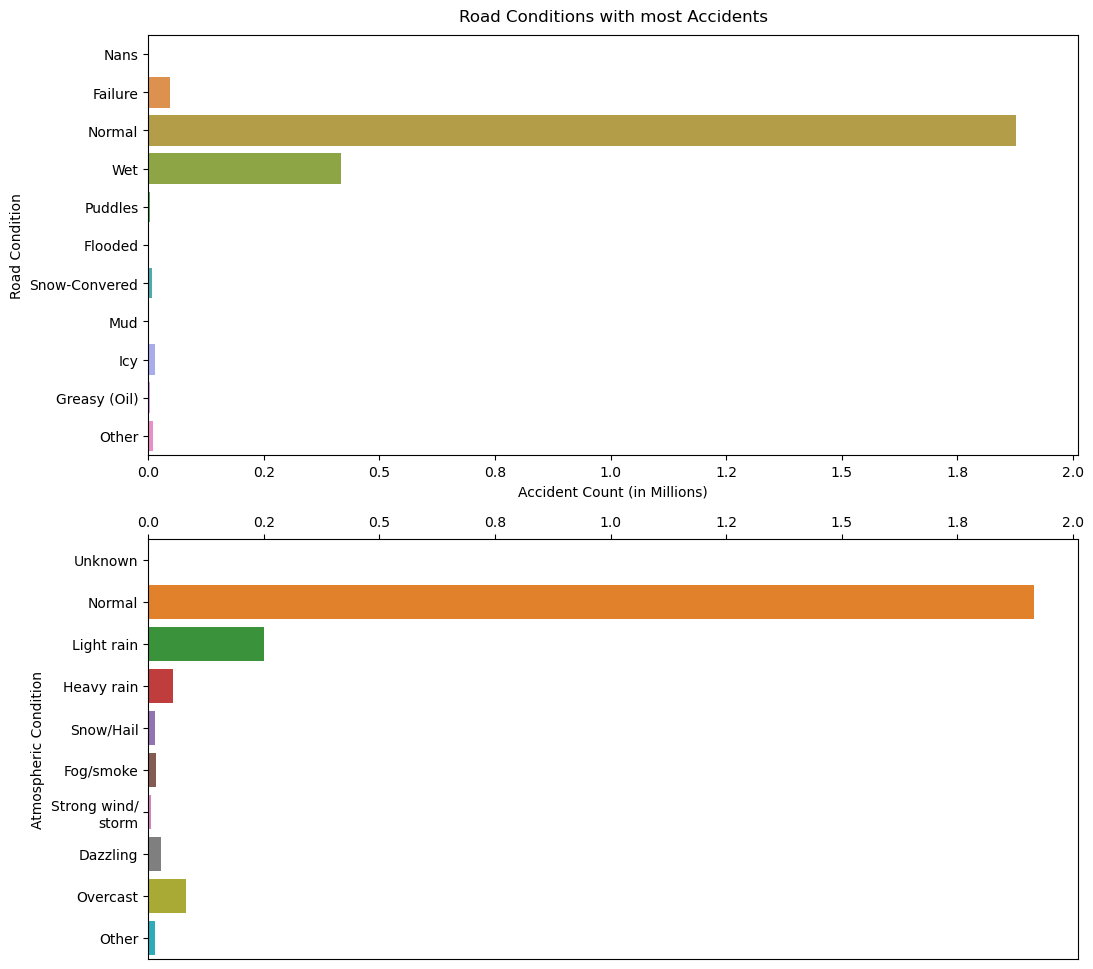

In [59]:
plt.figure(figsize = (12,12));
ax1 = plt.subplot(2,1,1);
sns.countplot( y = df.Rd_Cond);
plt.title('Road Conditions with most Accidents', pad=10);
plt.yticks(ticks=list(range(0,11)),labels=['Nans','Failure','Normal','Wet','Puddles','Flooded','Snow-Convered',
                                           'Mud','Icy','Greasy (Oil)', 'Other']);
plt.ylabel('Road Condition');
#plt.ylim(top=1.5);
plt.xlabel('Accident Count (in Millions)');
locs,labels = plt.xticks();
plt.xticks(locs, map(lambda x: "%.1f" % x, locs*1e-6));

ax2 = plt.subplot(2,1,2, sharex=ax1);
sns.countplot( y = df['atmospheric_conditions']);
plt.yticks(ticks=list(range(10)),labels=['Unknown', 'Normal', 'Light rain', 'Heavy rain', 'Snow/Hail',
                'Fog/smoke', 'Strong wind/\nstorm', 'Dazzling',
                'Overcast', 'Other']);
plt.ylabel('Atmospheric Condition')
plt.xlabel(None)
plt.savefig('./figures/Accidents by Weather conditions.png')
#plt.xlabel('Accident Count (in Millions)');
#plt.xticks(locs, map(lambda x: "%.1f" % x, locs*1e-6));
ax2.xaxis.tick_top()
#fig.tight_layout(w_pad=2)


By far the most accidents happend during normal weather conditions.

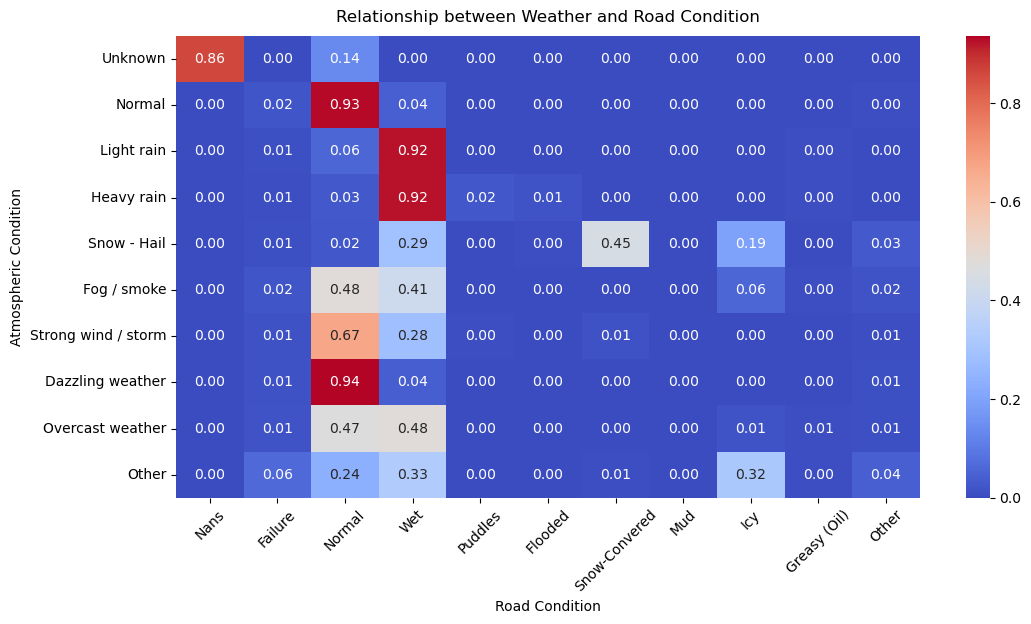

In [60]:
fig = plt.figure(figsize=(12,6));
sns.heatmap(pd.crosstab(df['atmospheric_conditions'], df['Rd_Cond'], 
                        normalize='index'), 
            annot=True, fmt='.02f', cmap='coolwarm',
            xticklabels=['Nans','Failure','Normal','Wet','Puddles','Flooded','Snow-Convered',
                                           'Mud','Icy','Greasy (Oil)', 'Other'],
            yticklabels=['Unknown', 'Normal', 'Light rain', 'Heavy rain', 'Snow - Hail',
                'Fog / smoke', 'Strong wind / storm', 'Dazzling weather',
                'Overcast weather', 'Other']);
plt.xlabel('Road Condition');
plt.ylabel('Atmospheric Condition');
plt.title('Relationship between Weather and Road Condition', pad=10);
plt.xticks(rotation=45)
plt.savefig('./figures/Relationship between Weather and Road Condition.png');

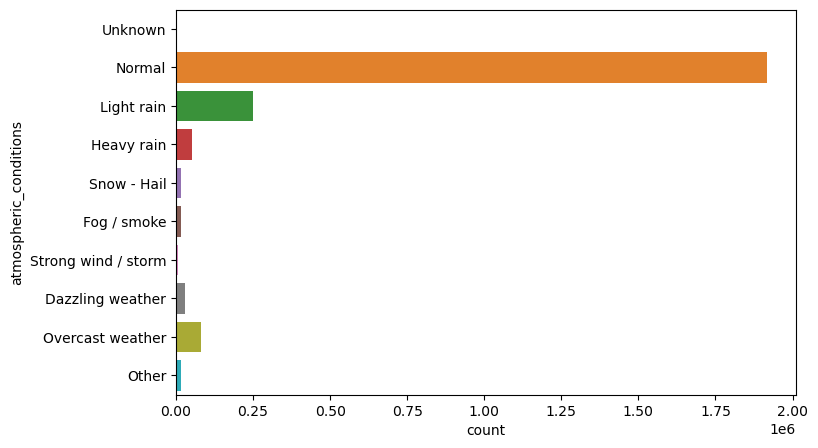

In [61]:
plt.figure(figsize = (8,5));
sns.countplot( y = df['atmospheric_conditions']);
plt.yticks(ticks=list(range(10)),labels=['Unknown', 'Normal', 'Light rain', 'Heavy rain', 'Snow - Hail',
                'Fog / smoke', 'Strong wind / storm', 'Dazzling weather',
                'Overcast weather', 'Other']);
#plt.title('Atmospheric Conditions with most Accidents', pad=10);
#plt.yticks(ticks=list(range(0,11)),labels=['Nans','Failure','Normal','Wet','Puddles','Flooded','Snow-Convered',
#                                           'Mud','Icy','Greasy (Oil)', 'Other']);
#plt.ylabel('Road Conditions');
#ylim(top=1.5);
#plt.xlabel('Accident Count ( in Millions )');
#locs,labels = xticks();
#xticks(locs, map(lambda x: "%.1f" % x, locs*1e-6));

## Locations

Are there areas of the road that are particularly often associated with accidents?

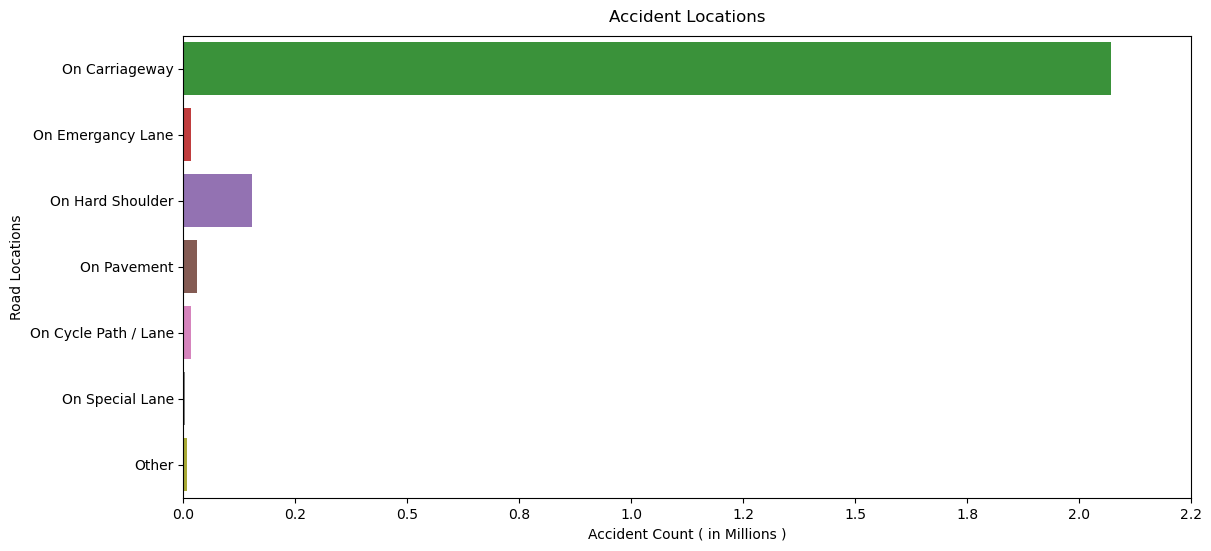

In [62]:
plt.figure(figsize = (13,6));
sns.countplot( y = df.Pos_Acc);
plt.title('Accident Locations', pad=10);
plt.ylabel('Road Locations');
plt.yticks(ticks=list(range(0,9)),labels=['Failure','Nans','On Carriageway', 
                                          'On Emergancy Lane', 'On Hard Shoulder', 
                                          'On Pavement' ,'On Cycle Path / Lane','On Special Lane' , 'Other']);
ylim(top=1.5);
plt.xlabel('Accident Count ( in Millions )')
locs,labels = xticks();
xticks(locs, map(lambda x: "%.1f" % x, locs*1e-6));
xlim(left=0)
plt.savefig('./figures/Accidents by Location.png');


By far the most accidents just happend directly on the carriage way.

## Chrashed Obstacle

Can traffic obstacles be a special index for accidents? It is to be expected that most accidents involving other road users occur in the form of vehicles.

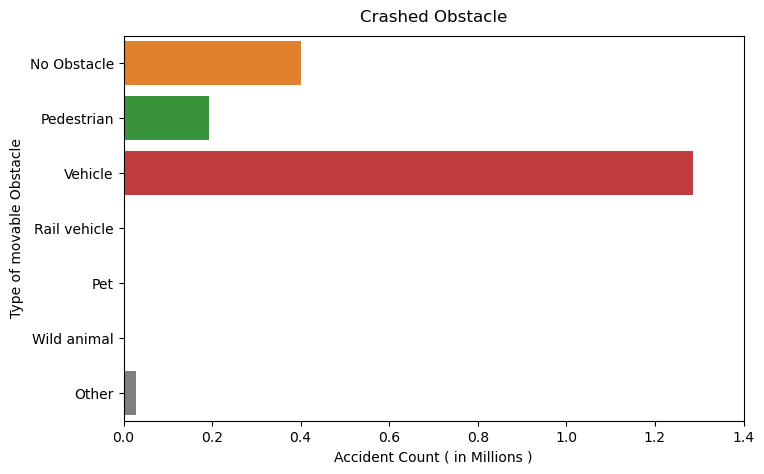

In [63]:
plt.figure(figsize = (8,5));
sns.countplot( y = vehicles.obstacle_movable);
plt.title('Crashed Obstacle', pad=10);
plt.ylabel('Type of movable Obstacle');
plt.yticks(ticks=list(range(0,8)),labels=['Nans','No Obstacle','Pedestrian', 'Vehicle', 'Rail vehicle', 'Pet' ,
                                          'Wild animal','Other']);
ylim(top=.5);
plt.xlabel('Accident Count ( in Millions )')
locs,labels = xticks();
xticks(locs, map(lambda x: "%.1f" % x, locs*1e-6));
xlim(left=0);
plt.savefig('./figures/Nb of Accidents per Crashed Obstacle.png')


Most crashed object during car accidents were other vehicles. Followed by no obstacle crashed and crashed pedestrians.

## Conclusion for Visualizations

In fact, accidents often do not seem to have been brought about by any particular external influence. Rather, physical conditions of road users such as tiredness, stress, the influence of alcohol and drugs or poor concentration could be the cause. This is of course a circumstance that is not easy to solve in order to be able to reduce the number of accidents in the future. Campaigns can only draw attention to the most common causes of accidents in France and the best way to counteract them.